In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from tqdm.auto import tqdm
import warnings

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Other
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [4]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,ORG ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org org annual report account year strong growth org one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [5]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [6]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_tokenized'], Y, test_size=0.2)

## 2. Classification with balanced weights

### 2.1. Logistic Regression

In [7]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1, 5, 10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.738 total time=14.6min
[CV 4/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.826 total time=39.3min
[CV 2/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.879 total time=21.8min
[CV 1/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.873 total time=14.3min
[CV 2/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.876 total time=12.8min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.743 total time= 6.2min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.740 total time= 6.4min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.743 total time= 4.5min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.823 total time=11.8min
[CV 5/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.823 total time=11.8min
[CV 3/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.829 total time= 7.4min
[CV 2/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.887 total time=55.6min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.746 total time=13.9min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.830 total time=34.2min
[CV 5/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.816 total time= 7.9min
[CV 3/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.884 total time=16.9min
[CV 4/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.887 total time=20.7min
[CV 3/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.883 total time=10.6min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.751 total time= 5.9min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.748 total time= 5.6min
[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.751 total time= 4.1min
[CV 5/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.825 total time=33.0min
[CV 3/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.882 total time=55.8min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.749 total time=13.3min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.822 total time=35.4min
[CV 4/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.886 total time=57.4min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.752 total time=14.4min
[CV 3/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.832 total time=35.4min
[CV 5/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.883 total time=56.9min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.745 total time= 6.6min
[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.744 total time= 5.1min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.749 total time= 4.6min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.820 total time=13.2min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.814 total time=11.5min
[CV 4/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.817 total time=10.8min
[CV 1/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.877 total time=21.2min
[CV 5/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.879 total time=23.0min
[CV 4/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.883 total time=11.9min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.740 total time=13.2min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.739 total time= 4.1min
[CV 3/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.832 total time=10.5min
[CV 4/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.825 total time=12.5min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.821 total time= 7.8min
[CV 1/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.879 total time=52.9min
[CV 5/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.877 total time= 9.8min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Best Parameters: {'clf__estimator__C': 10, 'tfidf__min_df': 1}
Mean cross-validated F1-score of the best estimator: 0.8837176394620858


              precision    recall  f1-score   support

           0       0.74      0.74      0.74       198
           1       0.87      0.91      0.89      1499
           2       0.84      0.92      0.88      1442
           3       0.84      0.90      0.87      1314
           4       0.90      0.84      0.87      1414
           5       0.88      0.82      0.85      1317
           6       0.84      0.88      0.86      1220
           7       0.70      0.73      0.72       191
           8       0.91      0.91      0.91      1544
           9       0.85      0.77      0.81      1151
          10       0.79      0.76      0.77       559
          11       0.84      0.88      0.86      1248
          12       0.70      0.73      0.72       191

   micro avg       0.85      0.86      0.86     13288
   macro avg       0.82      0.83      0.83     13288
weighted avg       0.86      0.86      0.86     13288
 samples avg       0.84      0.85      0.81     13288



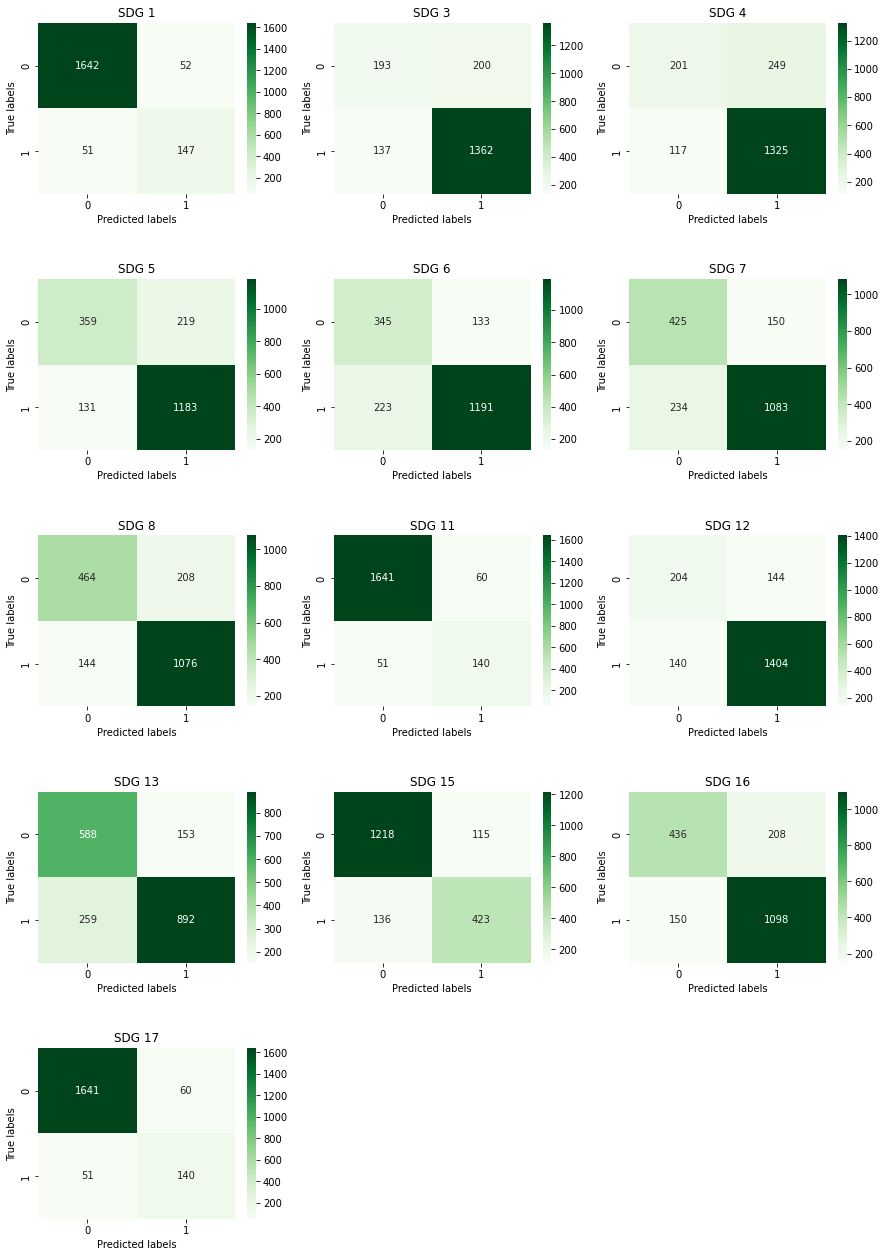

In [8]:
evaluation(grid_lr, X_test, Y_test)

### 2.2. Linear SVM

In [9]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1, 5, 10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.757 total time=346.0min
[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.750 total time=285.0min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.759 total time=344.6min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.752 total time=310.6min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.750 total time=406.8min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.865 total time=278.2min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.756 total time=406.1min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.748 total time=285.1min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.747 total time=404.8min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.757 total time=284.9min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.867 total time=243.

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       198
           1       0.86      0.94      0.90      1499
           2       0.83      0.93      0.88      1442
           3       0.82      0.92      0.87      1314
           4       0.88      0.91      0.89      1414
           5       0.86      0.88      0.87      1317
           6       0.82      0.89      0.85      1220
           7       0.84      0.70      0.76       191
           8       0.89      0.95      0.92      1544
           9       0.84      0.81      0.83      1151
          10       0.81      0.76      0.79       559
          11       0.81      0.92      0.86      1248
          12       0.84      0.70      0.76       191

   micro avg       0.85      0.89      0.87     13288
   macro avg       0.84      0.85      0.84     13288
weighted avg       0.85      0.89      0.87     13288
 samples avg       0.83      0.88      0.83     13288



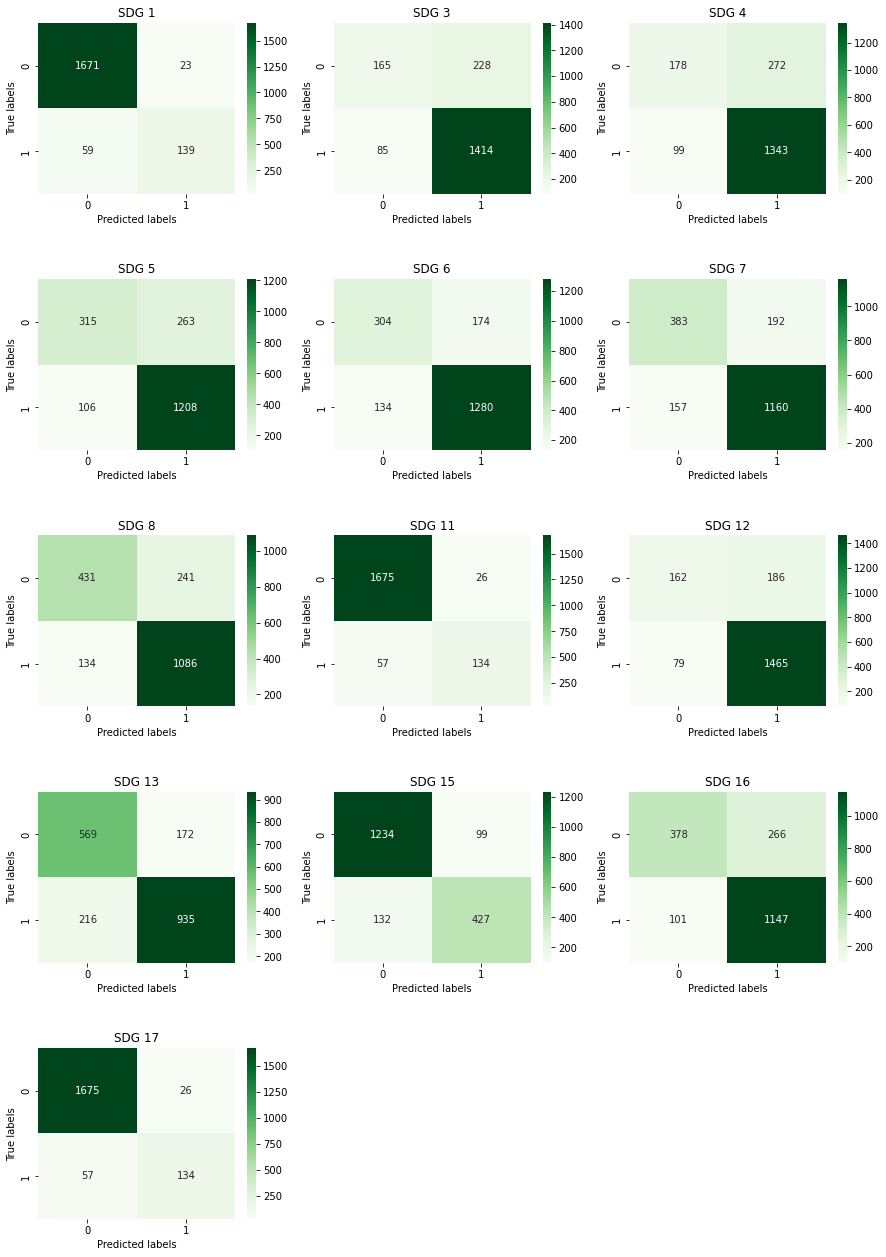

In [10]:
evaluation(grid_svm, X_test, Y_test)

### 2.3. Random Forest

In [11]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1, 5, 10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__min_df=1;, score=0.781 total time=24.0min
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=1;, score=0.794 total time=42.6min
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.776 total time=21.2min
[CV 4/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.779 total time=28.0min
[CV 3/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=10;, score=0.767 total time=19.5min
[CV 2/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100, tfidf__min_df=1;, score=0.754 total time=140.6min
[CV 3/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50, tfidf__min_df=1;, score=0.743 total time=308.1min
[CV 1/5] END clf__estimator__max_depth=None, clf__estimat

[CV 2/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.777 total time= 6.3min
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.800 total time= 9.0min
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__min_df=10;, score=0.802 total time= 9.4min
[CV 2/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=5;, score=0.786 total time=14.8min
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=5;, score=0.803 total time=14.0min
[CV 3/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.786 total time=10.5min
[CV 4/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=1;, score=0.770 total time=94.6min
[CV 2/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100, tfidf__min_df=5;, score=0.764 total time=35

              precision    recall  f1-score   support

           0       0.80      0.35      0.49       198
           1       0.87      0.85      0.86      1499
           2       0.84      0.88      0.86      1442
           3       0.84      0.82      0.83      1314
           4       0.90      0.76      0.82      1414
           5       0.85      0.75      0.80      1317
           6       0.84      0.79      0.81      1220
           7       0.81      0.38      0.51       191
           8       0.90      0.87      0.89      1544
           9       0.81      0.66      0.73      1151
          10       0.78      0.52      0.62       559
          11       0.82      0.75      0.78      1248
          12       0.76      0.39      0.52       191

   micro avg       0.85      0.77      0.81     13288
   macro avg       0.83      0.67      0.73     13288
weighted avg       0.85      0.77      0.80     13288
 samples avg       0.79      0.74      0.73     13288



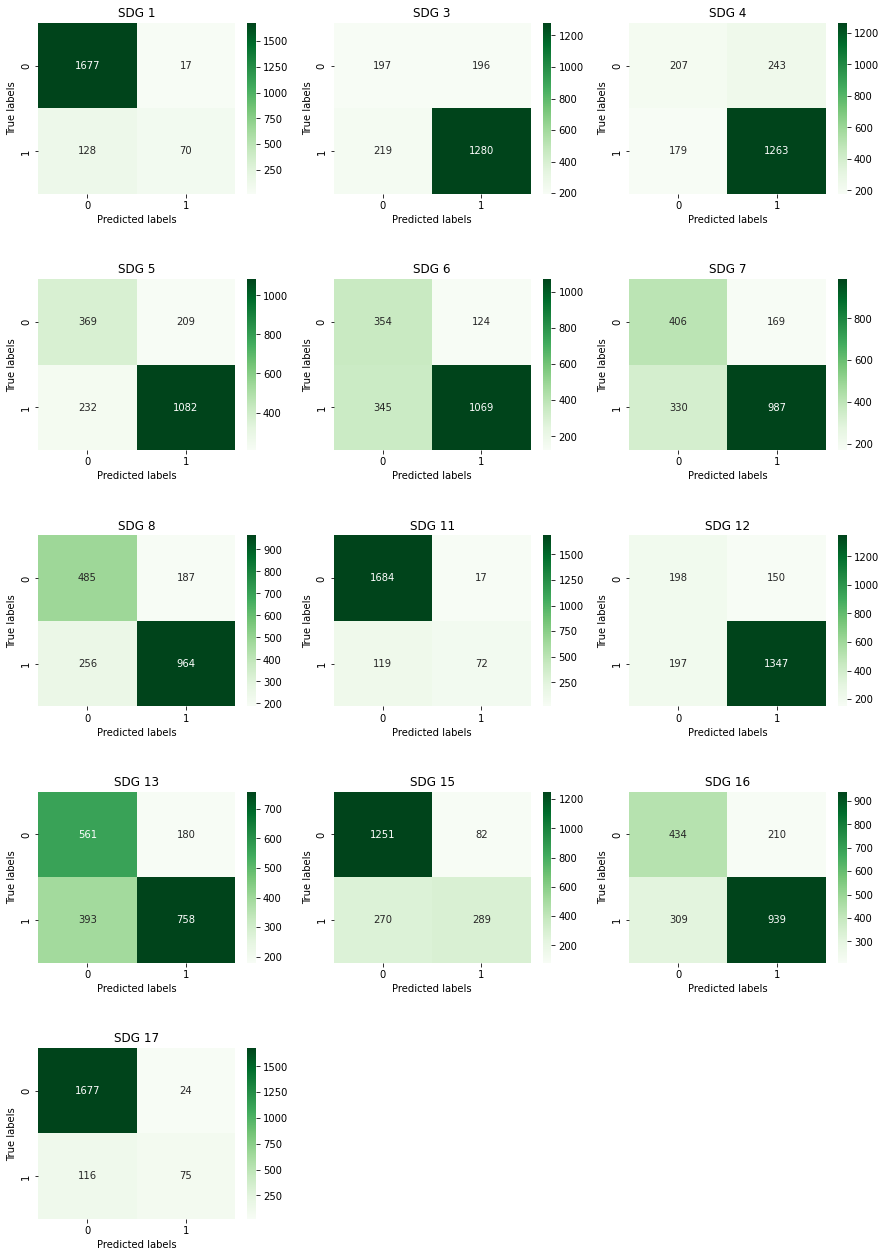

In [12]:
evaluation(grid_rf, X_test, Y_test)

## 3. Evaluation of best model

In [13]:
# Print configuration of best model
grid_svm.best_params_

{'clf__estimator__C': 10, 'tfidf__min_df': 5}

In [25]:
# Look at 10 most important words for each SDG 
i = 0
tfidf = grid_svm.best_estimator_.named_steps["tfidf"].get_feature_names()
for sdg in labels:
    coefs = np.transpose(grid_svm.best_estimator_.named_steps["clf"].estimators_[i].coef_.toarray())
    important_tokens = pd.DataFrame(data = coefs, index=tfidf, columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['orging', 'medicine', 'customer', 'loan', 'ni', 'lending', 'access', 'million', 'affordable', 'mobile']


SDG_3
['safety', 'health', 'supplier', 'mine', 'training', 'water', 'tax', 'chain', 'gri', 'facility']


SDG_4
['gri', 'training', 'fy fy', 'including', 'supplier', 'water', 'client', 'development', 'performance', 'learning']


SDG_5
['supplier', 'human right', 'right', 'global', 'human', 'goal', 'chain', 'waste', 'labor', 'supply chain']


SDG_6
['water', 'waste', 'site', 'goal', 'chain', 'supply chain', 'performance', 'supplier', 'manufacturing', 'supply']


SDG_7
['energy', 'renewable', 'product', 'million', 'global', 'sustainable', 'solar', 'renewable energy', 'carbon', 'goal']


SDG_8
['human right', 'right', 'human', 'supplier', 'global', 'labor', 'goal', 'chain', 'risk', 'covid']


SDG_11
['orging', 'medicine', 'customer', 'ni', 'loan', 'million', 'lending', 'access', 'affordable', 'mobile']


SDG_12
['supplier', 'water', 'waste', 'energy', 'performance', 'global', 'c

In [15]:
# Save model
joblib.dump(grid_svm.best_estimator_, 'models/tfidf_svm.p')

['models/tfidf_svm.p']